# Part 4: Computer-Aided Cell Factory Engineering

## 4.1 Reconstruction of GSM from reference sequence

Carveme is used below to reconstruct a GSM from the reference coding sequence of Synechocystis sp. PCC 6803. Carveme does this by integrating multiple data sources, such as NCBI Blast, to identify sequence homologies and relevant genes. The completeness of the GSM is then summarized using Memote, which reports how well mass and energy balances are closed.

In [1]:
%%time

# Use carveme to generate a GSM from the Synechocystis sequence
!carve --refseq GCF_000009725.1 --output Synechocystis_sp_PCC_6803.xml

# Generate memote report to evaluate model completeness.
!memote report snapshot Synechocystis_sp_PCC_6803.xml --filename Synechocystis_sp_PCC_6803.html

diamond v2.0.15.153 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 8
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: 
Percentage range of top alignment score to report hits: 10
Opening the database...  [0.042s]
Database: c:\program files\python37\lib\site-packages\carveme/data/generated/bigg_proteins.dmnd (type: Diamond database, sequences: 26727, letters: 11170577)
Block size = 2000000000
Opening the input file...  [0.023s]
Opening the output file...  [0s]
Loading query sequences...  [0.008s]
Masking queries...  [0.021s]
Algorithm: Double-indexed
Building query histograms...  [0.037s]
Allocating buffers...  [0s]
Loading reference sequences...  [0.017s]
Masking reference...  [0.149s]
Initializing temporary storage...  [0.003s]
Building reference histograms...  [0.

============================= test session starts =============================
platform win32 -- Python 3.7.0, pytest-4.6.11, py-1.11.0, pluggy-0.13.1
rootdir: c:\
plugins: anyio-3.5.0, dash-2.7.0
collected 146 items / 1 skipped / 145 selected

..\..\..\..\..\..\program files\python37\lib\site-packages\memote\suite\tests\test_annotation.py . [  0%]
..FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...F....F.F...F.FF.FFFFFFFFFF..         [ 44%]
..\..\..\..\..\..\program files\python37\lib\site-packages\memote\suite\tests\test_basic.py . [ 45%]
.....F........F.FFFFFF                                                   [ 60%]
..\..\..\..\..\..\program files\python37\lib\site-packages\memote\suite\tests\test_biomass.py . [ 60%]
F.......F                                                                [ 67%]
..\..\..\..\..\..\program files\python37\lib\site-packages\memote\suite\tests\test_consistency.py . [ 67%]
..ssssssssssssssssFFFF.F.FFF                                             [ 86%]
..\..\..\..\..\..

## 4.2 Import existing GSM from database and perform genome engineering
Here an existing GSM from literature for Synechcystis is imported from the file 'iSynCJ816.xml', which was downloaded and stored locally (https://www.sciencedirect.com/science/article/abs/pii/S2211926416304490?via%3Dihub). It can be seen that the model is comprised of 928 metabolites and 1044 reactions. We will define the objective function ourselves to investigate which growth conditions are optimal. Note that the medium uses the cobra default medium composition. In photoautotrophic experiments, Synechocystis is usually grown on BG-11 medium - this will be investigated later. Memote is used to summarize the completeness of the model.

In [43]:
%%time

from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite

# read in the published model from 'iSynCJ816.xml'
model = read_sbml_model('iSynCJ816.xml') # Joshi et al 2017
model
# model.medium

# Generate memote report to evaluate model completeness.
!memote report snapshot iSynCJ816.xml --filename iSynCJ816.html

============================= test session starts =============================
platform win32 -- Python 3.7.0, pytest-4.6.11, py-1.11.0, pluggy-0.13.1
rootdir: c:\
plugins: anyio-3.5.0, dash-2.7.0
collected 164 items / 1 skipped / 163 selected

..\..\..\..\..\..\program files\python37\lib\site-packages\memote\suite\tests\test_annotation.py . [  0%]
..FFFFFFFFF.FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF.FFFFFFFFFF..         [ 39%]
..\..\..\..\..\..\program files\python37\lib\site-packages\memote\suite\tests\test_basic.py . [ 40%]
.....F........F...F.FF                                                   [ 53%]
..\..\..\..\..\..\program files\python37\lib\site-packages\memote\suite\tests\test_biomass.py . [ 54%]
FFF...............FFFsssFFF                                              [ 70%]
..\..\..\..\..\..\program files\python37\lib\site-packages\memote\suite\tests\test_consistency.py F [ 71%]
FFssssssssssssssssFFFFFFFFF.                                             [ 88%]
..\..\..\..\..\..

Memote reports show that the GSM reconstructed from reference sequence using CarveMe scores 86% overall with 100% stoichiometric consistency and 99.9% mass balance, whereas the model reported in (Joshi et al, 2017), iSynCJ816, scores 71% overall with 0% in stoichiometric consistency and 0.1% mass balance. The Joshi 2017 model appears to have biggest deficiencies in reaction and gene annotations, which may be expected because Synechocystis is not as well studies as E. coli or S. cerevisiae.

## 4.3 Cell Factory Engineering
### 4.3.1 Addition of Heterologous Pathways for p-Coumaric Acid Production
Two major pathways exist for p-coumaric acid biosynthesis: the phenylalanine pathway and the tyrosine pathway. This study examines the phenylalanine pathway due to the complications presented by the fact that tyrosine is also a precursor for biomass formation, therefore a competitor to product formation. The cell below uses the Cobra package to define two new metabolites (trans-cinnamate and p-coumaric acid) and add them into reaction objects for inclusion in the GSM. Two new reactions are also defined to create the phenylalanine pathway based on (Gao, 2021) (https://doi.org/10.1016/j.algal.2020.102180). Both reactions are specified as 'demand reactions' because they are reactions which consume intracellular metabolites without transported them outside the cell.

In [44]:
model = read_sbml_model('iSynCJ816.xml') # Synechocystis_sp_PCC_6803.xml (carveme) or iSynCJ816.xml (lit)

# define metabolites
trans_Cinnamate = Metabolite(id = 'TRCI', compartment='c', name='trans-Cinnamate', formula='C9H8O2')
p_Coumaric_acid = Metabolite(id = 'PCOU', compartment='c', name='p-Coumaric acid', formula='C9H8O3')

# define reactions
phenylalanine_ammonia_lyase = Reaction('PAL') # R00697
phenylalanine_ammonia_lyase.gene_reaction_rule = '( PAL )'

trans_cinnamate_4_monooxygenase = Reaction('CYP73A') # R02253
trans_cinnamate_4_monooxygenase.gene_reaction_rule = '( CYP73A )'

# add metabolites to reactions
phenylalanine_ammonia_lyase.add_metabolites(({model.metabolites.phe__L_c : -1,
                                              trans_Cinnamate: 1,
                                              model.metabolites.nh3_c: 1
                                             }))
trans_cinnamate_4_monooxygenase.add_metabolites(({model.metabolites.o2_c : -1,
                                                  trans_Cinnamate: -1,
                                                  model.metabolites.nadph_c : -1,
                                                  p_Coumaric_acid: 1,
                                                  model.metabolites.h2o_c: 1,
                                                  model.metabolites.nadph_c : 1,
                                                 }))

# add reactions to model
model.add_reactions([phenylalanine_ammonia_lyase])
model.add_reactions([trans_cinnamate_4_monooxygenase])
model.add_boundary(model.metabolites.TRCI, type='demand') # demand reaction consumes an intracellular metabolite
model.add_boundary(model.metabolites.PCOU, type='demand') # demand reaction consumes an intracellular metabolite

# set model objective to maximize P-Coumaric acid
model.objective = 'CYP73A'

# save the model
from cobra.io import write_sbml_model
write_sbml_model(model, "iSynCJ816_PCOU.xml")

### 4.3.2 Calculation of Theoretical Maximum Yields
After addition of the heterologous pathways to the Joshi 2017 model, several objective functions were optimized for comparison of theoretical maximum yields. Optimizations were performed using the default medium of the model. When the objective is set for CYP73A (i.e., p-Coumaric acid production) the rate and yield on glucose are 3.48e-5 mmol/gDW/h and 4.10e-5 mmol-pcou/mmol-glcD, respectively. For autotrophic biomass growth, it is 3.42e-5 mmol/gDW/h and 0.09 mmol-biomass/mmol-glc-D. For heterotrophic growth, it is 3.48e-5 mmol/gDW/h and 0.092 mmol-biomass/mmol-glc-D. The p-coumaric acid production rate is the same when the objective function is set as either p-coumaric acid or heterotrophic biomass production. Because the productivities of the autotrophic and heterotrophic growth models are very similar, it may be possible to exploit the autotrophic capability of Synechocystis on a "cheaper" medium to produce coumaric acid more competitively. Note however that the model returns an optimum value for the autotrophic growth model on glucose substrate, without specifying any photon flux. This is a potential model inaccuracy - we will investigate this next by implementing the common BG-11 medium for photoautotrophic growth.

In [4]:
temp_model = model # copy of model for testing different objective functions
temp_model.objective = 'CYP73A'
sol = temp_model.optimize()

obj_rate = sol.objective_value # AKA productivity of CYP73A reaction
print('Maximum rate p-coumaric acid is:  ', obj_rate, 'mmol/gDW/h')

# Define yield on glucose uptake, which is included in default medium. Note, EX_co2_e is null.
max_yield = obj_rate / (temp_model.reactions.EX_glc__D_e.flux)
print('Maximum theoretical yield:  ', max_yield, 'mmol-pcou/mmol-glcD')

Maximum rate p-coumaric acid is:   3.4849238349761794e-05 mmol/gDW/h
Maximum theoretical yield:   -4.0999103940896226e-05 mmol-pcou/mmol-glcD


In [5]:
temp_model = model # copy of model for testing different objective functions
temp_model.objective = 'BIOMASS_Ec_SynAuto_1'
sol = temp_model.optimize()

obj_rate = sol.objective_value # AKA productivity of autotrophic biomass growth
print('Maximum rate photoautotrophic biomass:  ', obj_rate, 'mmol/gDW/h')
print('Corresponding p-coumaric acid rate:  ', temp_model.reactions.CYP73A.flux, ' mmol/gDW/h')

# Define yield on glucose uptake, which is included in default medium. Note, EX_co2_e is null.
max_yield = obj_rate / (temp_model.reactions.EX_glc__D_e.flux)
print('Maximum theoretical yield:  ', max_yield, 'mmol-biomass/mmol-glcD')

Maximum rate photoautotrophic biomass:   0.07654252310456353 mmol/gDW/h
Corresponding p-coumaric acid rate:   3.4189248795024954e-05  mmol/gDW/h
Maximum theoretical yield:   -0.09005002718183945 mmol-biomass/mmol-glcD


In [6]:
temp_model = model # copy of model for testing different objective functions
temp_model.objective = 'BIOMASS_Ec_SynHetero_1'
sol = temp_model.optimize()

obj_rate = sol.objective_value # AKA productivity of autotrophic biomass growth
print('Maximum rate heterotrophic biomass:  ', obj_rate, 'mmol/gDW/h')
print('Corresponding p-coumaric acid rate:  ', temp_model.reactions.CYP73A.flux, ' mmol/gDW/h')

# Define yield on glucose uptake, which is included in default medium. Note, EX_co2_e is null.
max_yield = obj_rate / (temp_model.reactions.EX_glc__D_e.flux)
print('Maximum theoretical yield:  ', max_yield, 'mmol-biomass/mmol-glcD')

Maximum rate heterotrophic biomass:   0.07802010063372741 mmol/gDW/h
Corresponding p-coumaric acid rate:   3.4849238349975165e-05  mmol/gDW/h
Maximum theoretical yield:   -0.09178835368673814 mmol-biomass/mmol-glcD


One unresolved observation to point out is the fact that a higher p-Coumaric acid production rate is computed when the reconstructed GSM (via carveme) is used with heterologous pathways added. In this case, the rate of p-Coumaric acid is 0.067 mmol/gDW/h and a yield of 6.70 mmol-pcou/mmol-glcD, significantly higher than the iSynCJ816 model. One possible explanation is offered by the memote reports, which indicate higher completness for the reconstructed GSM. Also note that neither model considers whether p-Coumaric acid has a cytotoxic effect on the cell, which would limit both product and biomass formation. Despite these inconsistencies, this study will focus on implementing computer-aided strain engineering tools in order to explore the current state-of-the-art model, instead of attempting to develop an updated model, which likely requires more laboratory experimentation to be effective.

In [14]:
# Useful lines for understanding results

# model.medium
# model.exchanges
# model.metabolites.query('p-Coumaric acid')
# model.reactions.get_by_id('EX_co2_e')
# model.metabolites.get_by_id('cit_e')
# model.slim_optimize() # returns just objective value, not entire solution object
# solution_bg11.fluxes
# model.summary()
# model.metabolites.nadph_c.summary()
# model.metabolites.PCOU.summary()
# model.reactions.DM_PCOU
# solution_default.fluxes

### 4.3.3 BG-11 Medium
The model built by Joshi et al 2017 includes the default medium choice, but the typical medium for photosynthetic Synechocystis cultivation, that was also used by Gao 2021, is BG-11. If it were possible to produce p-Coumaric acid photosynthetically, the growth medium would be essentially free. Add BG-11 into the model. BG-11 components: https://utex.org/products/bg-11-medium?variant=30991786868826 The upper limit for photon exchange is 95 mmol/gDW/h, as reported by Touloupakis 2015 (https://doi.org/10.1186/s13068-015-0319-7).

In [45]:
BG11 = {} # medium is a dictionary of exchange fluxes and their upper bounds

# components comprising BG-11 medium, maximum allowable flux values for simulation
BG11['EX_na1_e'] = 10 # from sodium nitrate, sodium EDTA, sodium carbonate
BG11['EX_k_e'] = 10 # from potassium phosphate
BG11['EX_pi_e'] = 10 # from dipotassium phosphate
BG11['EX_h_e'] = 10 # from dipotassium phosphate
BG11['EX_mg2_e'] = 10 # from magnesium sulfate
BG11['EX_ca2_e'] = 10 # from calcium chloride
BG11['EX_cit_e'] = 10 # from citric acid
BG11['EX_fe3_e'] = 10 # from ferric ammonium citrate
BG11['EX_nh4_e'] = 10 # from ferric ammonium citrate
BG11['EX_no3_e'] = 10 # from sodium nitrate
BG11['EX_hco3_e'] = 10 # from sodium carbonate
BG11['EX_so4_e'] = 10 # from sodium thiosulfate
BG11['EX_mn2_e'] = 1 # from BG-11 trace metals solution
BG11['EX_zn2_e'] = 1 # from BG-11 trace metals solution
BG11['EX_mobd_e'] = 1 # from BG-11 trace metals solution
BG11['EX_cu2_e'] = 1 # from BG-11 trace metals solution
BG11['EX_cobalt2_e'] = 1 # from BG-11 trace metals solution

# other components in typical cultivations
BG11['EX_co2_e'] = 100 # ambient carbon dioxide
BG11['EX_h2o_e'] = 100 # ambient water, default bounds allow in/out
BG11['EX_o2_e'] = 100 # ambient oxygen, default bounds allow in/out
BG11['EX_photon_e'] = 100 # light

# investigate growth
with model:
    print('BG-11 CYP73A Objective')
    model.medium = BG11
    model.objective = 'CYP73A'
    sol = model.optimize()
    print('Maximum rate p-coumaric acid is:  ', sol.objective_value, 'mmol/gDW/h')
    max_yield = (model.reactions.CYP73A.flux) / (model.reactions.EX_co2_e.flux)
    print('Yield on CO2:  ', max_yield, ' mmol-pcou/mmol-co2 \n')
    
with model:
    print('BG-11 Autotrophic Objective')
    model.medium = BG11
    model.objective = 'BIOMASS_Ec_SynAuto_1'
    sol = model.optimize()
    print('Maximum rate p-coumaric acid is:  ', model.reactions.CYP73A.flux, 'mmol/gDW/h')
    max_yield = (model.reactions.CYP73A.flux) / (model.reactions.EX_co2_e.flux)
    print('Yield on CO2:  ', max_yield, ' mmol-pcou/mmol-co2 \n')
    
with model:
    print('BG-11 Heterotrophic Objective')
    model.medium = BG11
    model.objective = 'BIOMASS_Ec_SynHetero_1'
    sol = model.optimize()
    print('Maximum rate p-coumaric acid is:  ', model.reactions.CYP73A.flux, 'mmol/gDW/h')
    max_yield = (model.reactions.CYP73A.flux) / (model.reactions.EX_co2_e.flux)
    print('Yield on CO2:  ', max_yield, ' mmol-pcou/mmol-co2 \n')
    
with model:
    print('BG-11 Mixotrophic Objective')
    model.medium = BG11
    model.objective = 'BIOMASS_Ec_SynMixo_1'
    sol = model.optimize()
    print('Maximum rate p-coumaric acid is:  ', model.reactions.CYP73A.flux, 'mmol/gDW/h')
    max_yield = (model.reactions.CYP73A.flux) / (model.reactions.EX_co2_e.flux)
    print('Yield on CO2:  ', max_yield, ' mmol-pcou/mmol-co2 \n')


BG-11 CYP73A Objective
Maximum rate p-coumaric acid is:   0.00041791346360864345 mmol/gDW/h
Yield on CO2:   1.4824215960634245e-05  mmol-pcou/mmol-co2 

BG-11 Autotrophic Objective
Maximum rate p-coumaric acid is:   0.00038988933483724564 mmol/gDW/h
Yield on CO2:   1.3770897636133757e-05  mmol-pcou/mmol-co2 

BG-11 Heterotrophic Objective
Maximum rate p-coumaric acid is:   0.0004169049180658413 mmol/gDW/h
Yield on CO2:   1.4786151448191538e-05  mmol-pcou/mmol-co2 

BG-11 Mixotrophic Objective
Maximum rate p-coumaric acid is:   0.00041791346360864345 mmol/gDW/h
Yield on CO2:   1.4824215960634242e-05  mmol-pcou/mmol-co2 



According to this analysis, Synechocystis growth on BG-11 media (i.e., purely photosynthetic) results in greater p-Coumaric acid production in comparison to the complete medium used by the model default. The p-coumaric acid production rate is highest when the model objective is set either CYP73A or Mixotrophic biomass formation. The productivity for both is 0.000418 mmol/gDW/h. The productivity is only slightly lower when the objective is heterotrophic biomass formation, 0.000417 mmol/gDW/h, and for autotrophic biomass formation, 0.000390 mmol/gDW/h. It is unclear why the model gives a result for heterotrophic growth when no carbon source other than CO2 is specified. Note, this calculation cannot be replicated for the reconstructed GSM from Carveme because it does not include the photosynthetic reactions.

### 4.3.4 Optimization for Minimal Medium
A minimal medium is desirable because it removes unneed components which do not add to value to microbial growth but add cost to the process. The Cobra function minimal_medium can be used to compute various possible minimal medium composition which also achieve the same value as the optimal model after optimization for the specified objective value. The function does not compute which possibility is lowest cost, for example, but the options may provide suggestions for medium optimization strategies.

In [8]:
from cobra.medium import minimal_medium

with model:
    print('Default Medium')
    sol = model.optimize()
    max_rate = model.reactions.CYP73A.flux
    print('p-Coumaric acid rate:  ', max_rate, 'mmol/gDW/h \n')
    min_med = minimal_medium(model, max_rate, minimize_components=8, open_exchanges=False)
    display(min_med)
    
with model:
    print('BG-11 Medium')
    model.medium = BG11
    sol = model.optimize()
    max_rate = model.reactions.CYP73A.flux
    print('p-Coumaric acid rate:  ', max_rate, 'mmol/gDW/h \n')
    min_med = minimal_medium(model, max_rate, minimize_components=True)
    display(min_med)

with model:
    print('BG-11 Medium with Extra Glucose')
    BG11['EX_glc__D_e'] = 10 # extra glucose
    model.medium = BG11
    model.objective = 'BIOMASS_Ec_SynMixo_1'
    sol = model.optimize()
    max_rate = model.reactions.CYP73A.flux
    print('p-Coumaric acid rate:  ', max_rate, 'mmol/gDW/h \n')
    min_med = minimal_medium(model, max_rate, minimize_components=True)
    display(min_med)

Default Medium
p-Coumaric acid rate:   3.484923835016425e-05 mmol/gDW/h 



EX_ca2_e        1.572398e-07
EX_cobalt2_e    1.133402e-07
EX_cu2_e        1.048265e-07
EX_fe3_e        4.983905e-07
EX_glc__D_e     5.387924e-04
EX_k_e          5.896491e-06
EX_mg2_e        1.002414e-06
EX_mn2_e        1.055583e-07
EX_mobd_e       1.055688e-07
EX_na1_e        1.319741e-07
EX_no3_e        3.139639e-04
EX_o2_e         5.351024e-04
EX_pi_e         2.400789e-05
EX_so4_e        6.612068e-06
EX_zn2_e        1.048265e-07
dtype: float64

BG-11 Medium
p-Coumaric acid rate:   0.0004169049180658413 mmol/gDW/h 



EX_ca2_e        0.000002
EX_cit_e        0.007583
EX_cobalt2_e    0.000001
EX_cu2_e        0.000001
EX_fe3_e        0.000006
EX_k_e          0.000071
EX_mg2_e        0.000012
EX_mn2_e        0.000001
EX_mobd_e       0.000001
EX_na1_e        0.000002
EX_nh4_e        0.003757
EX_o2_e         0.012492
EX_pi_e         0.000287
EX_so4_e        0.000079
EX_zn2_e        0.000001
dtype: float64

BG-11 Medium with Extra Glucose
p-Coumaric acid rate:   0.0008106824020119863 mmol/gDW/h 



EX_ca2_e        0.000004
EX_cit_e        0.001011
EX_cobalt2_e    0.000003
EX_cu2_e        0.000002
EX_fe3_e        0.000012
EX_glc__D_e     0.007341
EX_k_e          0.000137
EX_mg2_e        0.000023
EX_mn2_e        0.000002
EX_mobd_e       0.000002
EX_na1_e        0.000003
EX_nh4_e        0.007306
EX_o2_e         0.012993
EX_pi_e         0.000558
EX_so4_e        0.000154
EX_zn2_e        0.000002
dtype: float64

Above is the result for the minimal medium analysis. The optimal BG-11 medium is given, which is seen to produce more p-coumaric acid than the default medium. It is also seen that adding D-glucose to BG-11 does not increase the production rate. This is likely because sufficient CO2 and light are present to reach maximal production under photosynthetic conditions.

In [30]:
%%time

BG11.pop('EX_glc__D_e', None)
model.objective = 'CYP73A'
model.medium = BG11
sol = model.optimize() # optimize on BG-11 medium

# save the model
from cobra.io import write_sbml_model
write_sbml_model(model, "iSynCJ816_PCOU_BG11.xml")

# Generate memote report to evaluate model completeness.
!memote report snapshot iSynCJ816_PCOU_BG11.xml --filename iSynCJ816_PCOU_BG11.html

Wall time: 28.1 ms


## 4.4 Phenotypic Phase Planes

Synechocystis has potential to be a versatile production host. Let's explore some key process parameters for the modes it might operate in, such as aerobic v. anaerbobic, amount of light, amount of CO2, and amount of other carbon sources.

In [10]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

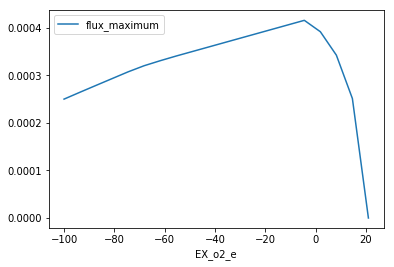

In [12]:
# For oxygen
ppp_pcou = production_envelope(model,
                               reactions=[model.reactions.EX_o2_e],
                               objective=model.reactions.CYP73A)
ppp_pcou.plot(x='EX_o2_e', y='flux_maximum')

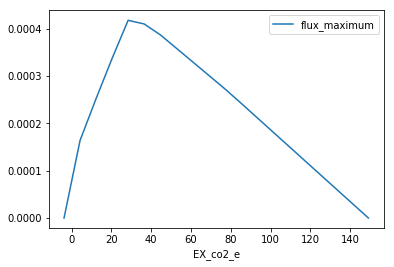

In [13]:
# For CO2
ppp_pcou = production_envelope(model,
                               reactions=[model.reactions.EX_co2_e],
                               objective=model.reactions.CYP73A)
ppp_pcou.plot(x='EX_co2_e', y='flux_maximum')

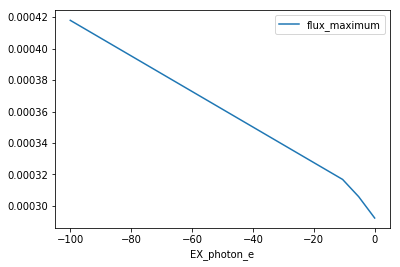

In [14]:
# For light
ppp_pcou = production_envelope(model,
                               reactions=[model.reactions.EX_photon_e],
                               objective=model.reactions.CYP73A)
ppp_pcou.plot(x='EX_photon_e', y='flux_maximum')

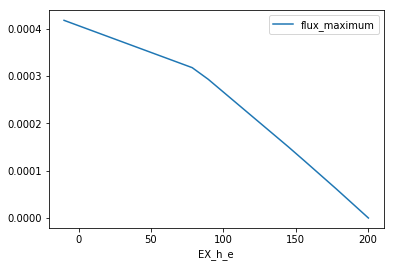

In [15]:
# For H+
ppp_pcou = production_envelope(model,
                               reactions=[model.reactions.EX_h_e],
                               objective=model.reactions.CYP73A)
ppp_pcou.plot(x='EX_h_e', y='flux_maximum')

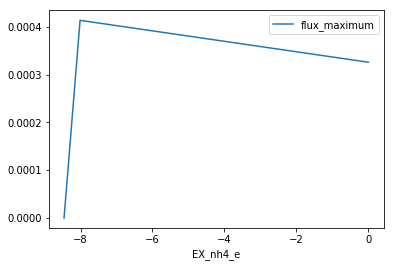

In [16]:
# For NH4. Minimal medium analysis indicates this may be a limiting resource.
ppp_pcou = production_envelope(model,
                               reactions=[model.reactions.EX_nh4_e],
                               objective=model.reactions.CYP73A)
ppp_pcou.plot(x='EX_nh4_e', y='flux_maximum')

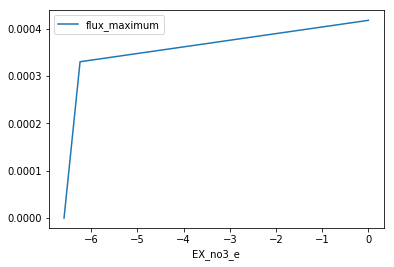

In [17]:
# For NO3. Minimal medium analysis indicates this may be a limiting resource.
ppp_pcou = production_envelope(model,
                               reactions=[model.reactions.EX_no3_e],
                               objective=model.reactions.CYP73A)
ppp_pcou.plot(x='EX_no3_e', y='flux_maximum')

In [18]:
# Check the combination of photosynthesis inputs
import plotly.graph_objects as go
import pandas as pd
import numpy as np

ppp_pcou = production_envelope(model,
                               reactions=[model.reactions.EX_photon_e,
                                          model.reactions.EX_co2_e],
                               objective=model.reactions.CYP73A)

# separate variables
X = ppp_pcou['EX_photon_e'].unique()
Y = ppp_pcou['EX_co2_e'].unique()
Z = ppp_pcou['flux_maximum'].values
Z = Z.reshape(len(X),len(Y))
X, Y = np.meshgrid(X, Y)

# plot with plotly
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(title='p-Coumaric acid Productivity [mmol/gDW/h]', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_xaxes(title_text='Photon exchange [mmol/gDW/h]')
fig.update_yaxes(title_text='CO2 exchange [mmol/gDW/h]')
fig.show()

The phenotypic phase planes show a few useful relationships. Light is limiting below an exchange rate around 8000. CO2 is limiting above an exchange rate around 27000, though not clear why. NH4 and NO3 are both shown to be beneficial for production when imported into the cell, perhaps due to charge and redox balancing. Lastly, high exchange rates of oxygen in and out of the cell limits production, possibly due to thermodynamic equilibrium.

## 4.5 Computational Enumeration of Production Pathways
### 4.5.1 Algorithmic computation using cameo
The previous section made use of a rational genetic engineering strategy reported in literature to introduce the heterologous pathway for p-coumaric acid into Synechocystis. Two reactions were needed. Can we do better? This section will use Cameo to predict if other production strategies may be possible.

In [47]:
from IPython.display import display
from cameo.strain_design import pathway_prediction # Need jinja2==2.7.3? Just for visualization of results.
from cameo import api
from cameo.parallel import MultiprocessingView

#api.products.search('coumaric')
predictor = pathway_prediction.PathwayPredictor(model)
pathways = predictor.run(product="coumarin", max_predictions=4)
pathways

# try high-level interface to test for alternatives
# mp_view = MultiprocessingView()
# api.design.options.max_pathway_predictions = 4
# api.design.options.heuristic_optimization_timeout = 30
# report = api.design(product='coumarin', view=mp_view)

No heterologous pathways were suggested by cameo. The script was run on a Windows 10 64-bit machine with Intel Core i7 8th gen processor. Possible reasons may be that the host organism, Synechocystis, is not available in Cameo or that the pathway has already been added to the model. Running the PathwayPredictor again on the base model also produced no results, so the organism is likely undefined. Literature reports showed that only two heterologous reactions had to be added to produce p-coumaric acid, which is a low number and the strategy used so for in this report. For that reason, we will focus on gene knockout and coupling strategies instead of alternative production pathways.

### 4.5.2 Visualization of production pathways
No alternative pathways were suggested by the cameo strain designer. Have a look at the current production pathway. Escher cannot be used to see the production pathway because it does not support Synechocystis. Check out the KEGG pathways instead. These show the reaction, R02253, and also the important precursors. The key precursor for for R02253 is phenylalanine. It is interesting to note that p-Coumaric acid can also be produced from tyrosine using R00737. The tyrosine pathway will be explored in section 4.10.3.

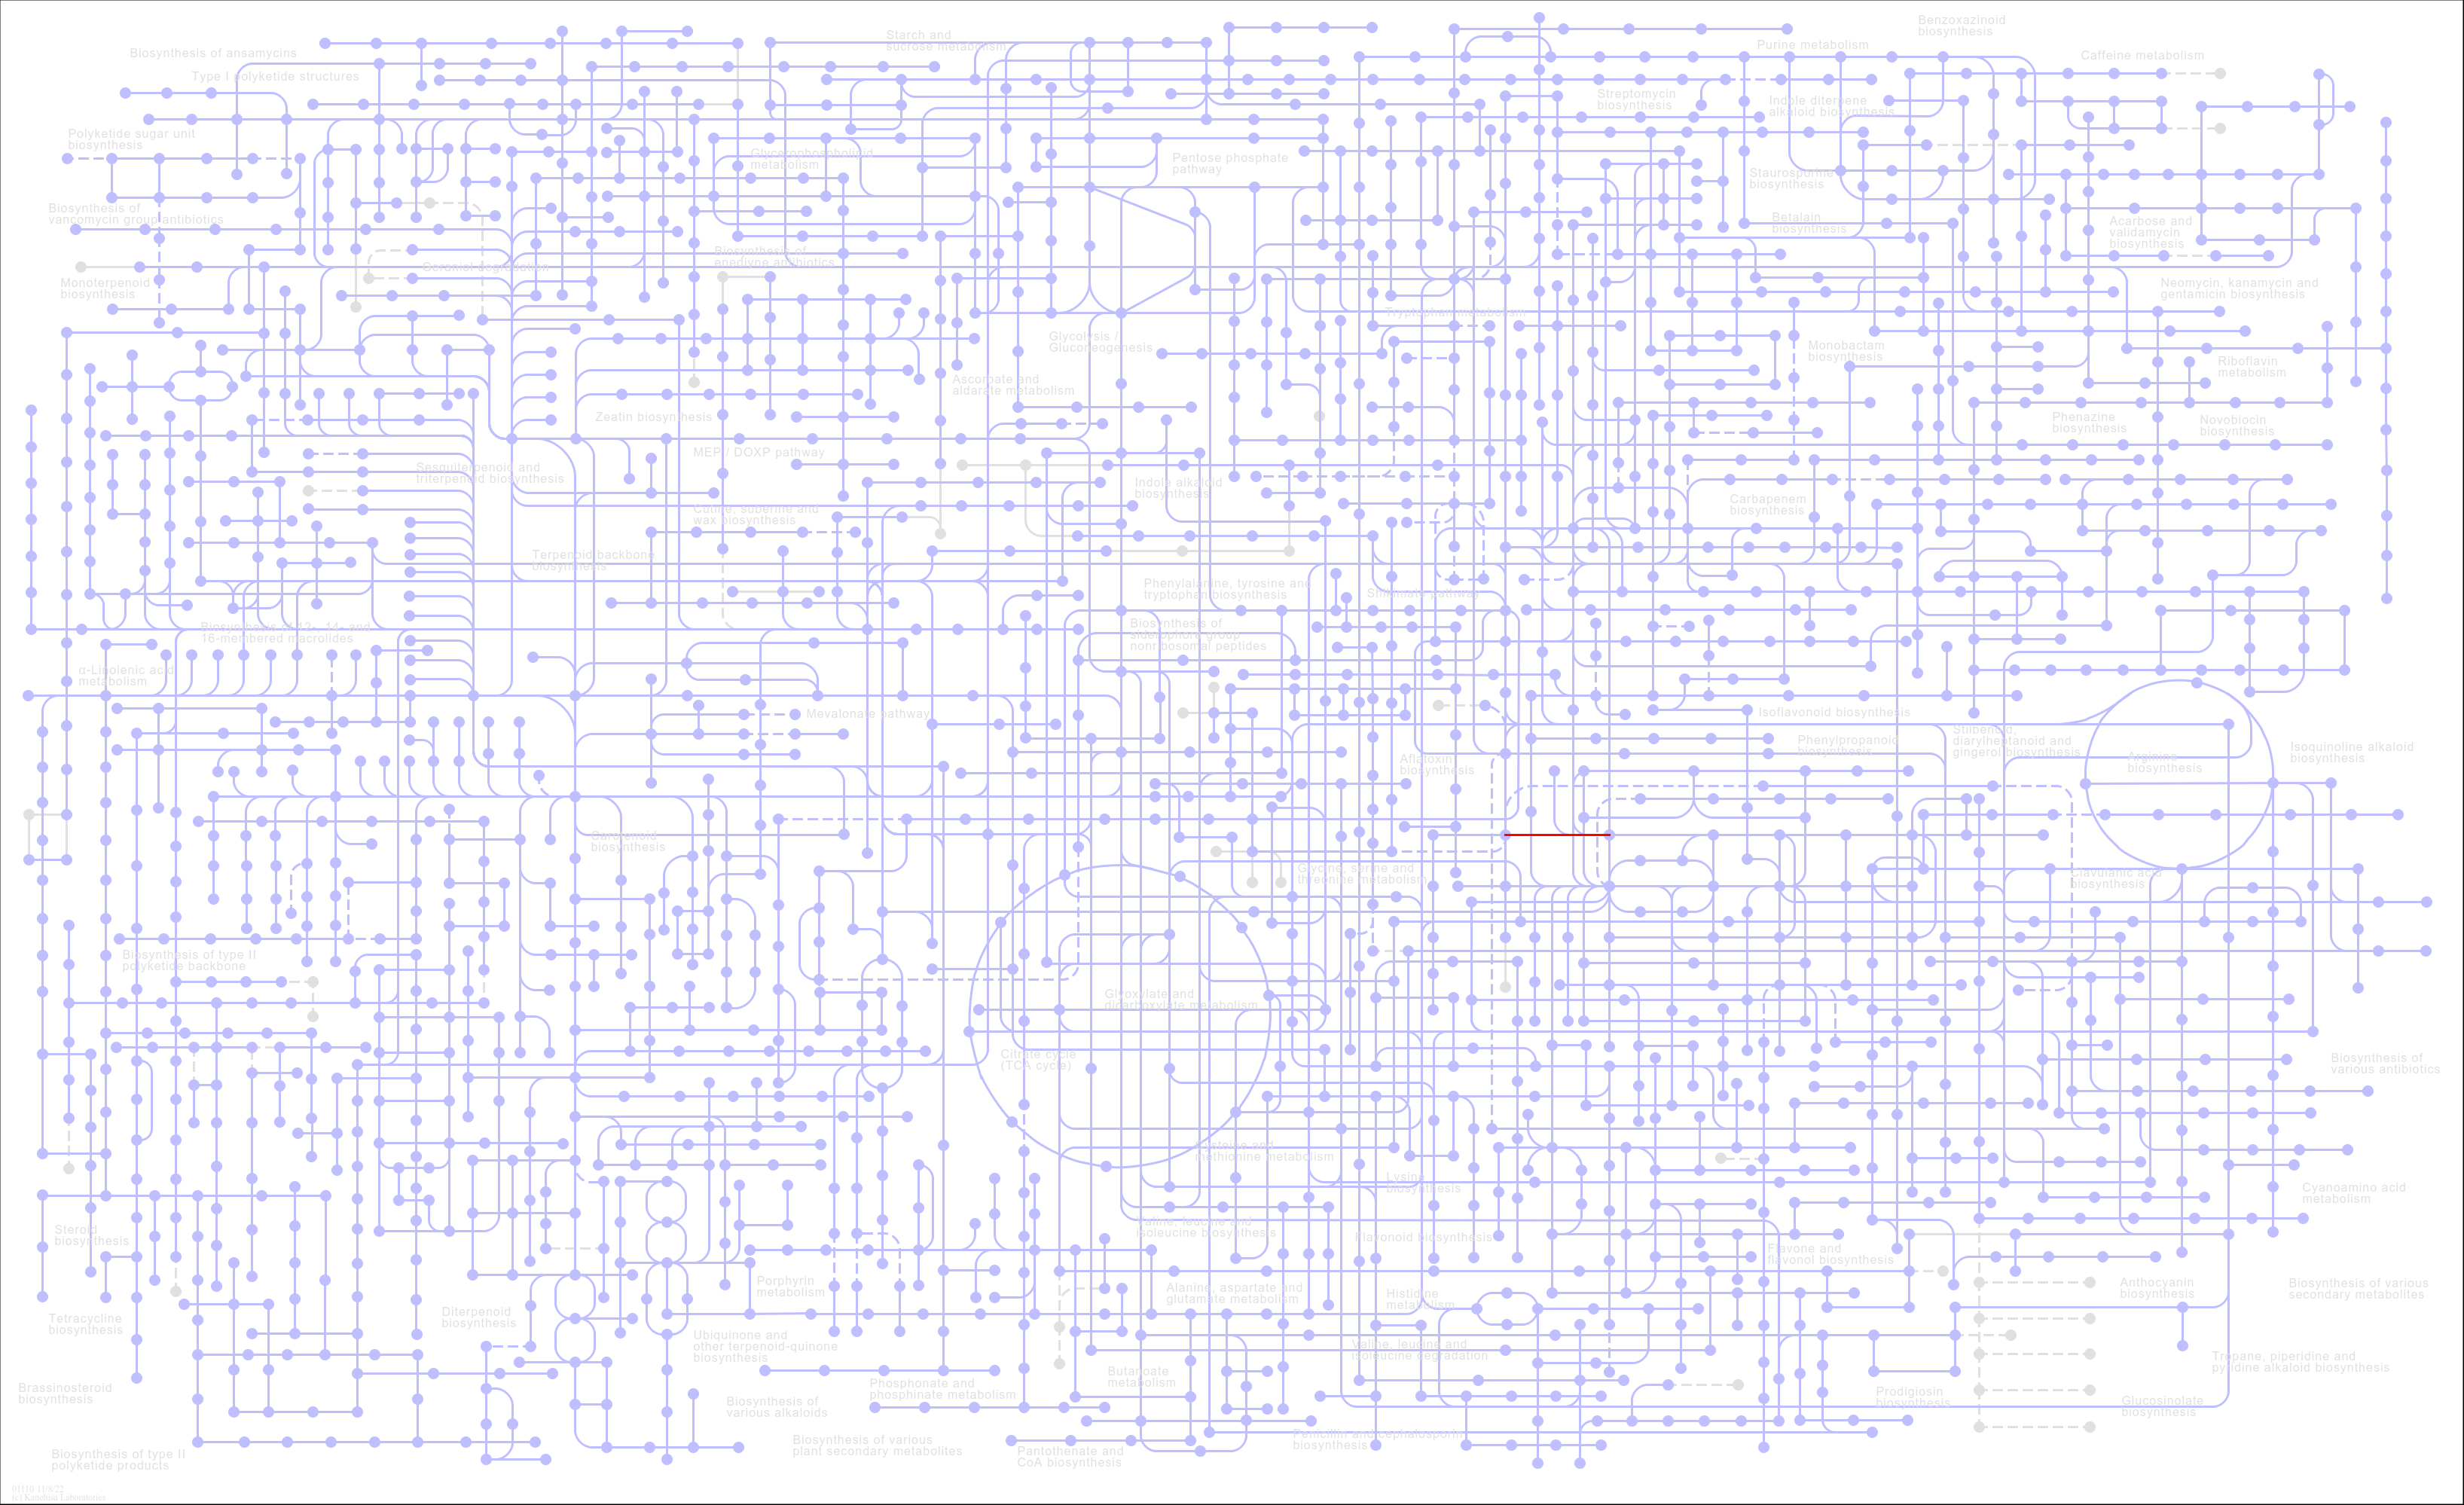

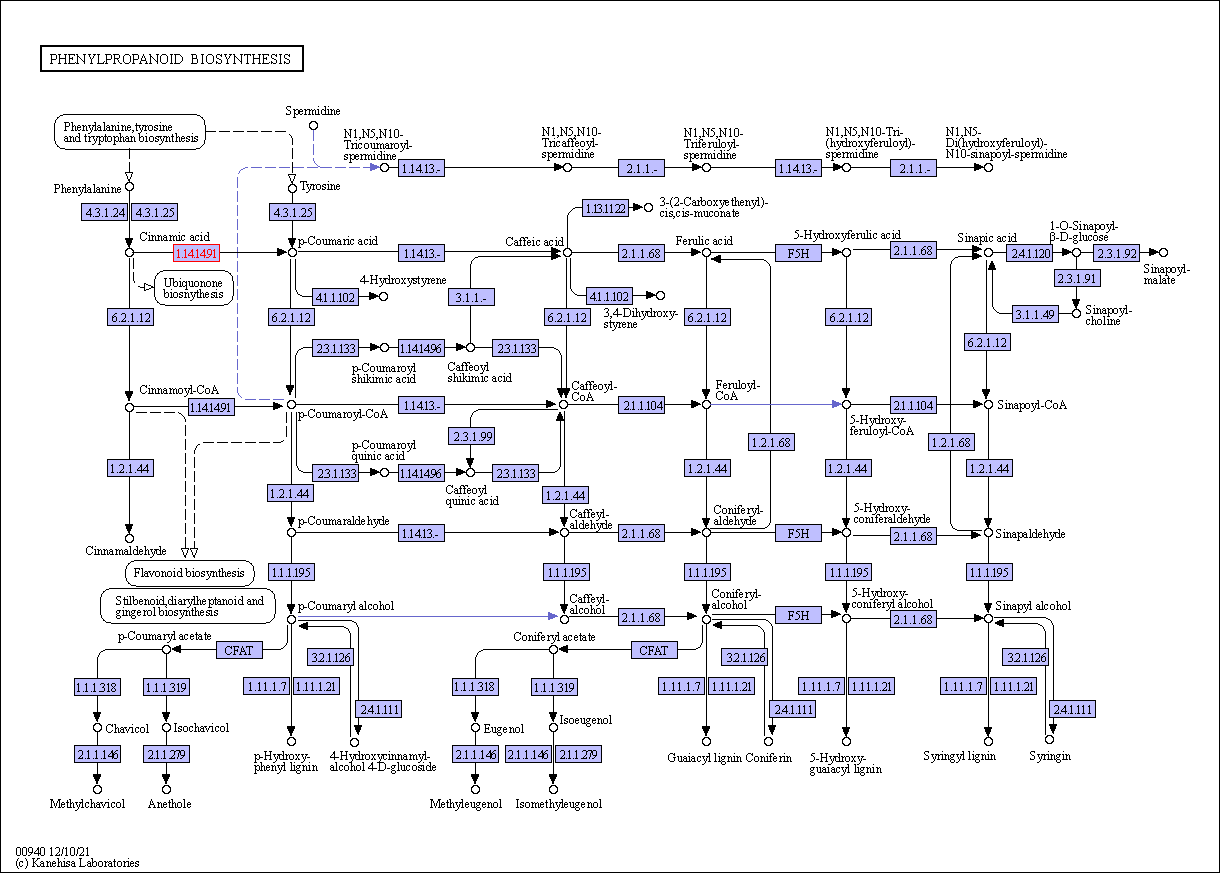

## 4.6 Computation of Gene Knock-Out Strategies
### 4.6.1 KOs via OptGene
Use OptGene to algorithmically check for viable gene knock out strategies. It is difficult to produce any viable results with OptGene for the iSynCJ816 model optimized for mixotrophic growth on BG-11 medium, which was identified as the best growth strategy above. OptGene did not return KOs for any growth mode (i.e., hetero-, mixo-, or autotrophic growth) for CYP73A objective and CO2 substrate. At least 2000 evaluations were performed for each run of the algorithm. Some KOs are suggested, however, when the model medium is reverted to an exploratory state used early in the analysis. By expanding the flux limits for the CO2, O2, H20, and Photon exchange reactions, OptGene does return results for the mixotrophic model for CYP73A objective on CO2 substrate. Results follow.

In [41]:
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
from cameo.strain_design import OptGene

optgene = OptGene(model)
result_OptGene = optgene.run(target=model.reactions.CYP73A,
                             biomass=model.reactions.BIOMASS_Ec_SynMixo_1,
                             substrate=model.metabolites.co2_e,
                             max_evaluations=4000,
                             plot=False)
result_OptGene

Starting optimization at Tue, 29 Nov 2022 00:39:33


HBox()

Finished after 00:23:20


In [42]:
# analyze OptGene candidate KOs

# dir(result_hetero) # useful to understand object attributes
print('10 Candidate KO Strategies\n')
top_10 = result_OptGene.data_frame.sort_values(by=['yield'], ascending=False).head(n=10)
print( top_10[['reactions','genes','yield','fitness']])

# plot phenotypic phase plane for best KO candidate
from cameo import phenotypic_phase_plane
plotter = PlotlyPlotter()
p = phenotypic_phase_plane(model, variables=['BIOMASS_Ec_SynMixo_1'], objective='CYP73A')
p.plot(plotter, points=[(sol.fluxes['BIOMASS_Ec_SynMixo_1'], sol.fluxes['CYP73A'])])
result_OptGene.plot(plotter, 1)

10 Candidate KO Strategies

Empty DataFrame
Columns: [reactions, genes, yield, fitness]
Index: []


KeyError: 1

Under these conditions, OptGene returns 5 candidate KOs where the best is a two gene KO including SGL_RS08865 and SGL_RS17045, resulting in a yield and fitness of 0.000039 and 0.000086, respectively. These genes encode the Glyceraldehyde-3-phosphate dehydrogenase and a potassium periplasm ABC transporter. This result is a decrease from the wild type fitness.

On a previous run of the algorithm using the same conditions, OptGene suggested 29 possible KOs where the best KO was a two-gene KO involving the genes SGL_RS11980 and SGL_RS08035, which results in a yield and fitness of 0.000795 mmol-pcou/mmol-co2 and 0.001764, respectively, while maintaining target and biomass flux. Phenotypic phase planes recapitulated this result by tracing the phenotypic curve for WT and KO over the same points. Note that this yield was an improvement over the wild type yield, 3.14e-5 mmol-pcou/mmol-co2. The KO corresponds to the 4 reactions (PGK, GLNabcpp, LYSabcpp, ARGabcpp) AKA (Phosphoglycerate kinase, L-glutamine transport, L-lysine transport, and L-arginine transport). These reactions are important for the uptake of nutrients, in this case amino acids, into the cell. This is likely a consequence of setting such high exchange reaction flux values for the photosynthesis reactants. Forcing the simulation to a likely impossibly high rate of photosynthesis will make the transport of common precursors for heterotrophic growth irrelevant and therefore candidates for KOs. The result may still be useful however because we may be able to anticipate a useful strategy. By leveraging the photosynthetic capabilities of Synechocystis, the amino acid transport reactions are no longer needed. Other amino acid ABC transport reactions are also suggested by OptGene as KO candidates, so this may be used as a motif for a broader KO strategy. As Mogens Kilstrup once said, "Don't fuck with central metabolism," so these ancillary transporter genes are great KO candidates. Verification would require laboratory experimentation.

Note that pathway visualizations are not available in the Escher package for Synechocystis because its metabolism is not as well understood as S. cerevisiae or E. coli, which are the primary organisms supported by Escher.

One hypothesis for why the KO algorithms do not suggest many options is that, as a photosynthetic organism, Synechocystis is already optimized for autotrophic growth. It is a simple and well defined mode of growth with only three reactants (CO2, H2O, and light) necessary for photosynthesis, so little extra cellular machinery is needed in comparison to heterotrophic growth modes, which must hedge resources to produce catabolic proteins for many possible substrates. 

Next try the OptKnock algorithm.

### 4.6.2 KOs via OptKnock
OptKnock, another KO algorithm available in cameo, performs a similar KO computation but with a less computationally-intense algorithm. Here it is run below.


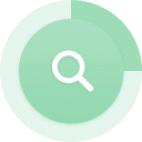

<IPython.core.display.Javascript object>

HBox()

In [19]:
# OptKnock
from cameo.strain_design import OptKnock

optknock = OptKnock(model, fraction_of_optimum=0.85)
result_optknock = optknock.run(max_knockouts=4, 
                               target="CYP73A", 
                               biomass="BIOMASS_Ec_SynMixo_1",
                               substrate=model.metabolites.co2_e)
result_optknock

OptKnock does not suggest any candidate KOs for a fraction_of_optimum=0.85.

### 4.6.3 Implementation of KOs in optimized model
Perform best KOs suggested by OptGene and OptKnock.

In [40]:
print('OptKnock run 1 KOs:  ')
# These KOs are from an OptGene run that suggested eliminated AA ABC transporters.
# The original run was done on BG-11 medium with wide photosynthesis reactant flux limits (+10000).
# The result could not be reproduced. Here is the KO anyway.
temp_model_1 = model # copy of model for testing KOs
#temp_model.objective = 'BIOMASS_Ec_SynMixo_1'
temp_model_1.reactions.PGK.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.LYSabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.GLNabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.ARGabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.UREAabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.PROabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.LEUabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.GLYabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.ALAabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.HISabcpp.bounds = 0, 0 # OptKnock run 1
temp_model_1.reactions.SERabcpp.bounds = 0, 0 # OptKnock run 1
sol_1 = temp_model_1.optimize()
print('KO p-coumaric acid rate:  ', sol_1.objective_value, 'mmol/gDW/h')
max_yield = (temp_model_1.reactions.CYP73A.flux) / (temp_model_1.reactions.EX_co2_e.flux)
print('Yield on CO2:  ', max_yield, ' mmol-pcou/mmol-co2 \n')


print('OptKnock run 2 KOs:  ')
# These KOs are from another OptGene run that suggested eliminating different enzymes.
# This run was also done on BG-11 medium with wide photosynthesis reactant flux limits (+10000).
# The result could not be reproduced. Here is the KO anyway.
temp_model_2 = model # copy of model for testing KOs
#temp_model.objective = 'BIOMASS_Ec_SynMixo_1'
temp_model_2.reactions.GAPDi_nadp.bounds = 0, 0 # OptKnock run 2
temp_model_2.reactions.Kabcpp.bounds = 0, 0 # OptKnock run 2
sol_2 = temp_model_2.optimize()
print('KO p-coumaric acid rate:  ', sol_2.objective_value, 'mmol/gDW/h')
max_yield = (temp_model_2.reactions.CYP73A.flux) / (temp_model_2.reactions.EX_co2_e.flux)
print('Yield on CO2:  ', max_yield, ' mmol-pcou/mmol-co2 \n')

OptKnock run 1 KOs:  
KO p-coumaric acid rate:   0.0003967249369704051 mmol/gDW/h
Yield on CO2:   1.4026988368982185e-05  mmol-pcou/mmol-co2 

OptKnock run 2 KOs:  
KO p-coumaric acid rate:   0.0003967249369704051 mmol/gDW/h
Yield on CO2:   1.4026988368982185e-05  mmol-pcou/mmol-co2 



Implementation of the suggested KOs under the expected actual growth condition (i.e., autotrophic growth on BG-11) does not result in any improvement. Both yield and productivity are reduced. There may be a few reasons for this. First, the model, which scored low in the memote report, may not be handling high production rates well due to poor stoichiometric and energy balancing. Or, because the medium is specified with an upper bound of essentially infinite light, it might be possible that the model is producing more energy than is realistic and eclipsing whatever maintenance energy reductions are achieved by the KOs.

## 4.7 Up/Down regulation

> See 4_expression-modulation-targets

## 4.8 Cofactor swap targets

> See 4_cofactor-swaps

## 4.9 Dynamic FBA simulating batch cultivation

## 4.10 Alternative pathways, rational strategies, and manual KOs

### 4.10.1 PPOR and PPND knockout

Two different knockout strategies were tested to optimize p-coumaric flux. Knocout targets were selected based on KEGG pathways metabolic analysis and similar experiments from literature. These knockouts would theoretically reduce competition and would redirect more carbon to p-coumaric production pathway. 

The phenylpyruvate oxidoreductase (PPOR) is an enzyme catalyzing the conversion of phenylpyruvate into 2-hydroxyphenylacetate. Phenylpyruvate is the precursor of phenylalanine, so in theory PPOR knockout would increase the flux through phenylalanine biosynthesis. 

The prephenate dehydrogenase (PPND) catalyzes the conversion of prephenate into 3-4-Hydroxyphenylpiruvate, which will be converted into tyrosine by tyrosine transaminase (TYRTA) in the next reaction. Knockout of tyrosine biosynthetic enzyme genes has shown to increase flux through p-coumaric production without disturbing *Synechocystis* metabolism (Gao, 2021). Hence, we decided to knockout PPND. 

In [31]:
#Autotrophic
model = read_sbml_model('iSynCJ816_PCOU.xml')

with model as model:
    model.reactions.PPND.bounds = 0, 0
    model.reactions.PPOR.bounds = 0, 0
    print("PPND's bounds inside the with statement:")
    print(model.reactions.PPND.lower_bound, model.reactions.PPND.bounds)
    print("PPOR's bounds inside the with statement:")
    print(model.reactions.PPOR.lower_bound, model.reactions.PPOR.bounds)
    model.reactions.EX_photon_e.bounds = 0, 50
    model.reactions.RBPC_1.bounds = 2.97, 3.54
    model.objective=model.reactions.BIOMASS_Ec_SynAuto_1
    maximum_growth_hetero = model.optimize().objective_value #flux
    print('Maximum growth =', maximum_growth_hetero, 'h-1')
    p_coumaric_production = model.reactions.CYP73A.flux
    print('Maximum productivity =', p_coumaric_production, 'mmol p-coumaric/gDW*h')
    maximum_yield_co2 = p_coumaric_production / (1*(model.reactions.RBPC_1.flux)) #yield calculations
    print('Maximum theoretical yield on co2 =', maximum_yield_co2, 'mmol-p_coumaric/mmol-co2')

PPND's bounds inside the with statement:
0 (0, 0)
PPOR's bounds inside the with statement:
0 (0, 0)
Maximum growth = 0.0 h-1
Maximum productivity = 0.0 mmol p-coumaric/gDW*h
Maximum theoretical yield on co2 = 0.0 mmol-p_coumaric/mmol-co2


In [32]:
#Mixotrophic
model = read_sbml_model('iSynCJ816_PCOU.xml')

with model as model:
    model.reactions.PPND.bounds = 0, 0
    model.reactions.PPOR.bounds = 0, 0
    print("PPND's bounds inside the with statement:")
    print(model.reactions.PPND.lower_bound, model.reactions.PPND.bounds)
    print("PPOR's bounds inside the with statement:")
    print(model.reactions.PPOR.lower_bound, model.reactions.PPOR.bounds)
    model.reactions.EX_photon_e.bounds = 0, 95
    model.reactions.RBPC_1.bounds = 2.97, 3.54
    model.objective=model.reactions.BIOMASS_Ec_SynMixo_1
    maximum_growth_mixo = model.optimize().objective_value #flux
    print('Maximum growth =', maximum_growth_mixo, 'h-1')
    p_coumaric_production = model.reactions.CYP73A.flux
    print('Maximum productivity =', p_coumaric_production, 'mmol p-coumaric/gDW*h')
    maximum_yield_co2 = p_coumaric_production / (1*(model.reactions.RBPC_1.flux)) #yield calculations
    print('Maximum theoretical yield on co2 =', maximum_yield_co2, 'mmol-p_coumaric/mmol-co2')
    maximum_yield_glucose = p_coumaric_production / (-1*(model.reactions.EX_glc__D_e.flux)) #yield calculations
    print('Maximum theoretical yield on glucose =', maximum_yield_glucose, 'mmol-p-coumaric/mmol-glucose')

PPND's bounds inside the with statement:
0 (0, 0)
PPOR's bounds inside the with statement:
0 (0, 0)
Maximum growth = 0.0 h-1
Maximum productivity = 0.0 mmol p-coumaric/gDW*h
Maximum theoretical yield on co2 = 0.0 mmol-p_coumaric/mmol-co2
Maximum theoretical yield on glucose = 0.0 mmol-p-coumaric/mmol-glucose


In [33]:
#Heterotrophic
model = read_sbml_model('iSynCJ816_PCOU.xml')

with model as model:
    model.reactions.PPND.bounds = 0, 0
    model.reactions.PPOR.bounds = 0, 0
    print("PPND's bounds inside the with statement:")
    print(model.reactions.PPND.lower_bound, model.reactions.PPND.bounds)
    print("PPOR's bounds inside the with statement:")
    print(model.reactions.PPOR.lower_bound, model.reactions.PPOR.bounds)
    model.reactions.RBPC_1.bounds = 0, 0
    model.objective=model.reactions.BIOMASS_Ec_SynHetero_1
    maximum_growth_hetero = model.optimize().objective_value #flux
    print('Maximum growth =', maximum_growth_hetero, 'h-1')
    p_coumaric_production = model.reactions.CYP73A.flux
    print('Maximum productivity =', p_coumaric_production, 'mmol p-coumaric/gDW*h')
    maximum_yield_glucose = p_coumaric_production / (-1*(model.reactions.EX_glc__D_e.flux)) #yield calculations
    print('Maximum theoretical yield on glucose =', maximum_yield_glucose, 'mmol-p-coumaric/mmol-glucose')

PPND's bounds inside the with statement:
0 (0, 0)
PPOR's bounds inside the with statement:
0 (0, 0)
Maximum growth = 0.0 h-1
Maximum productivity = 0.0 mmol p-coumaric/gDW*h


ZeroDivisionError: float division by zero

##### Results

|  | Max. growth (h-1) | WT Max. productivity (mmol/g(DW)/h) | XAL Max. productivity (mmol/g(DW)/h)| Max. yield on glucose | Max yield on CO2
| :-: | :-: | :-: | :-: | :-: | :-: |
| Autotrophic | 3.43E-17| 3.41E-5| 4.51E-15 | --- | 1.52E-15 |
| Mixootrophic | 2.74E-17 |3.48E-5 | 1.05E-15 | 1.2E-15 | 3.4E-16 |
| Heterotrophic | 0.0 | 3.48E-5 | 0.0| 0.0 | --- |


Results show that biomass growth is decreased to a very low levels, what can be explained as a result of tyrosine production inhibition because tyrosine is considered by the model to calculate the BIOMASS flux. Regarding the p-coumaric production, it also decreases to values much more lower compared to wild-type. The study carried out by Gao et al. (2021) revealed an increase of 54% in p-coumaric production when tyrosine pathway was knocked out. Thus, our model don't predict the *in-vitro* results and further optimization regarding other knock out targets should be done. 

### 4.10.2 Cloning of XAL enzyme

Another option to increase p-coumaric production would be to clone the gen encoding an enzyme able to directly convert L-tyrosine into p-coumaric acid in a sinlge reaction step. We select the enzyme XAL from *Trichosporon cutaneum*, which was already cloned and studied in *Synechocystis* sp. PCC6303 by Brel et al. (2020). XAL has both phenylalanine ammonia-lyase (PAL) and tyrosine ammonia-lyase (TAL) activity. Ideally, we clone the enzyme with a high constitutive expression system, which would redirect close to 100% tyrosine to p-coumaric conversion. Tyrosine and subproducts could be exogenously administered to ensure metabolic flux through the tyrosine related essential pathways. 

In [34]:
# read in the published model from 'iSynCJ816.xml'
model = read_sbml_model('iSynCJ816_PCOU.xml') # Joshi et al 2017

phenylalanine_ammonia_lyase2 = Reaction('PAL2')
tyrosine_ammonia_lyase = Reaction('TAL')
phenylalanine_ammonia_lyase2.add_metabolites(({model.metabolites.phe__L_c : -1,
                                               trans_Cinnamate: 1,
                                               model.metabolites.nh3_c: 1
                                              }))
tyrosine_ammonia_lyase.add_metabolites(({model.metabolites.tyr__L_c : -1,                                                                                            
                                         p_Coumaric_acid: 1,                                          
                                         model.metabolites.nh3_c : 1
                                        }))

model.add_reactions([phenylalanine_ammonia_lyase2])
model.add_reactions([tyrosine_ammonia_lyase])


When we optimize the flux through any the three biomass reactions, we see that TAL flux is 0. The reason is that tyrosine is considered by the model as a metabolite taking part in biomass reactions. As the flux is being optimized through biomass, there is no flux left for TAL. Our solution is to consider an ideal situation where all the tyrosine is converted into p-coumaric, thus using tyrosine formation flux through TYRTA (Tyrosine transaminase) as the hypothetical TAL flux. 

In [35]:
with model as model:
    model.objective=model.reactions.BIOMASS_Ec_SynMixo_1
    maximum_growth_mixo = model.optimize().objective_value #flux
    print('Maximum growth =', maximum_growth_mixo, 'h-1')
    TAL_flux=model.reactions.TAL.flux
    print('TAL flux =', TAL_flux, 'mmol/g(DW)/h')
    TYRTA_flux=model.reactions.TYRTA.flux
    print('TYRTA flux =', -1*TYRTA_flux, 'mmol/g(DW)/h')
    
model.metabolites.tyr__L_c.reactions


Maximum growth = 0.07802010063372752 h-1
TAL flux = 0.0 mmol/g(DW)/h
TYRTA flux = 0.010474978711084257 mmol/g(DW)/h


frozenset({<Reaction BIOMASS_Ec_SynAuto_1 at 0x253d98f3e48>,
           <Reaction BIOMASS_Ec_SynHetero_1 at 0x253d891f5c0>,
           <Reaction BIOMASS_Ec_SynMixo_1 at 0x253d98f3cf8>,
           <Reaction TAL at 0x253d433dd30>,
           <Reaction THZPSN2 at 0x253d9d55198>,
           <Reaction THZSN_1 at 0x253da0df048>,
           <Reaction TYRTA at 0x253d9e41c50>,
           <Reaction TYRTRS at 0x253d9cb8e10>})

In [36]:
#Autotrophic
with model as model:
    model.reactions.EX_photon_e.bounds = -50, 0
    model.reactions.RBPC_1.bounds = 2.97, 3.54
    model.objective=model.reactions.BIOMASS_Ec_SynAuto_1
    maximum_growth_hetero = model.optimize().objective_value #flux
    print('Maximum growth =', maximum_growth_hetero, 'h-1')
    p_coumaric_production = -model.reactions.TYRTA.flux + model.reactions.CYP73A.flux
    print('Maximum productivity =', p_coumaric_production, 'mmol p-coumaric/gDW*h')
    maximum_yield_co2 = p_coumaric_production / (1*(model.reactions.RBPC_1.flux)) #yield calculations
    print('Maximum theoretical yield on co2 =', maximum_yield_co2, 'mmol-p_coumaric/mmol-co2')

Maximum growth = 0.17433033139528262 h-1
Maximum productivity = 0.023483458422254667 mmol p-coumaric/gDW*h
Maximum theoretical yield on co2 = 0.007906888357661504 mmol-p_coumaric/mmol-co2


In [37]:
#Mixotrophic
with model as model:
    model.reactions.EX_photon_e.bounds = 0, 95
    model.reactions.RBPC_1.bounds = 2.97, 3.54
    model.objective=model.reactions.BIOMASS_Ec_SynMixo_1
    maximum_growth_mixo = model.optimize().objective_value #flux
    print('Maximum growth =', maximum_growth_mixo, 'h-1')
    p_coumaric_production = -model.reactions.TYRTA.flux + model.reactions.CYP73A.flux
    print('Maximum productivity =', p_coumaric_production, 'mmol p-coumaric/gDW*h')
    maximum_yield_co2 = p_coumaric_production / (1*(model.reactions.RBPC_1.flux)) #yield calculations
    print('Maximum theoretical yield on co2 =', maximum_yield_co2, 'mmol-p_coumaric/mmol-co2')
    maximum_yield_glucose = p_coumaric_production / (-1*(model.reactions.EX_glc__D_e.flux)) #yield calculations
    print('Maximum theoretical yield on glucose =', maximum_yield_glucose, 'mmol-p-coumaric/mmol-glucose')

Maximum growth = 0.07802010063372723 h-1
Maximum productivity = 0.01050982794943571 mmol p-coumaric/gDW*h
Maximum theoretical yield on co2 = 0.0035386626092376128 mmol-p_coumaric/mmol-co2
Maximum theoretical yield on glucose = 0.012364503469924366 mmol-p-coumaric/mmol-glucose


In [38]:
# Heterotrophic
with model as model:
    model.reactions.EX_photon_e.bounds = 0, 95
    model.reactions.RBPC_1.bounds = 0, 0
    model.objective=model.reactions.BIOMASS_Ec_SynHetero_1
    maximum_growth_hetero = model.optimize().objective_value #flux
    print('Maximum growth =', maximum_growth_hetero, 'h-1')
    p_coumaric_production = -model.reactions.TYRTA.flux + model.reactions.CYP73A.flux
    print('Maximum productivity =', p_coumaric_production, 'mmol p-coumaric/gDW*h')
    maximum_yield_glucose = p_coumaric_production / (-1*(model.reactions.EX_glc__D_e.flux)) #yield calculations
    print('Maximum theoretical yield on glucose =', maximum_yield_glucose, 'mmol-p-coumaric/mmol-glucose')

Maximum growth = 0.0780201006337274 h-1
Maximum productivity = 0.010509827949434272 mmol p-coumaric/gDW*h
Maximum theoretical yield on glucose = 0.012364503469922673 mmol-p-coumaric/mmol-glucose


##### Results

|  | Max. growth (h-1) | WT Max. productivity (mmol/g(DW)/h) | XAL Max. productivity (mmol/g(DW)/h)| Max. yield on glucose | Max yield on CO2
| :-: | :-: | :-: | :-: | :-: | :-: |
| Autotrophic | 0.174 | 7.78E-5| 0.0234 | --- | 0.0079 |
| Mixootrophic | 0.078 |3.48E-5 | 0.0105 | 0.012 | 0.0035 |
| Heterotrophic | 0.078 | 3.48E-5 | 0.0105 | 0.012 | --- |

These results show an increase in p-coumaric production with XAL. In the three scenarios, the increase in p-coumaric production is around 295 fold more. The study by Brel et al. (2020) showed an increase of 12 fold more, so our model predicts a higher improvement of p-coumaric production. However, further optimization of this cloning should be done, as we don't know if all the tyrosine can really be redirected through XAL flux *in vivo*. 

### 4.10.3 Tyrosine-only pathway
The pathway maps in section 4.5.2 above showed an possible alternative production pathway from tyrosine. Let's check what production would look like if R00737, the direct conversion of tyrosine to p-Coumaric acid, is implemented in Synechocystis instead of the current pathway from phenylalanine. The benefit would be that only a single reaction must be added.

In [39]:
model = read_sbml_model('iSynCJ816_PCOU_BG11.xml') # import specific model

with model:
    model.reactions.CYP73A.bounds = 0, 0 # adjust previous heterologous reaction to 0
    model.reactions.PAL.bounds = 0, 0 # adjust previous heterologous reaction to 0
    
    # no new metabolites must be defined
    trans_p_hydroxycinnamate = Reaction('TPHC') # R00737 for example from Rhodobacter sphaeroides
    trans_p_hydroxycinnamate.add_metabolites(({model.metabolites.tyr__L_c : -1,
                                               p_Coumaric_acid: 1,
                                               model.metabolites.nh3_c: 1
                                              }))
    model.add_reactions([trans_p_hydroxycinnamate])
    #model.add_boundary(model.metabolites.TPHC, type='demand') # not needed, already exists in model
    
    # modify bounds of medium due to huge prediction on first run
    model.reactions.EX_co2_e.bounds = -10, 100
    model.reactions.EX_photon_e.bounds = 0, 100
    
    model.objective = 'TPHC' # set new objective function
    sol = model.optimize()
    print('Maximum rate p-coumaric acid is:  ', sol.objective_value, 'mmol/gDW/h')
    max_yield = (model.reactions.TPHC.flux) / (model.reactions.EX_co2_e.flux)
    print('Yield on CO2:  ', max_yield, ' mmol-pcou/mmol-co2 \n')
    print('Biomass formation:  ', model.reactions.BIOMASS_Ec_SynMixo_1.flux, 'mmol/gDW//h')

Maximum rate p-coumaric acid is:   3.2036847492323446 mmol/gDW/h
Yield on CO2:   0.0964858199753391  mmol-pcou/mmol-co2 

Biomass formation:   0.0 mmol/gDW//h


Wow! That's a high productivity! As we can see, however, tyrosine is a critical precursor for biomass formation. By optimizing the simulation for p-coumaric acid formation, biomass formation was forced to zero. This is not viable. One idea to avoid this problem could be to engineer a genetic switch, to induce p-coumaric acid production only once Synechocystis has reached stationary phase, such that biomass and p-coumaric acid formation no longer compete. Such a strategy would require significant synthetic biology develeopment and is outside the scope of this project.

# References

>Brey, L. F., Włodarczyk, A. J., Thøfner, J. F. B., Burow, M., Crocoll, C., Nielsen, I., ... & Jensen, P. E. (2020). Metabolic engineering of Synechocystis sp. PCC 6803 for the production of aromatic amino acids and derived phenylpropanoids. Metabolic engineering, 57, 129-139.

>Brocks, J. J., Logan, G. A., Buick, R., & Summons, R. E. (1999). Archean molecular fossils and the early rise of eukaryotes. science, 285(5430), 1033-1036.

>Catherine, Q., Susanna, W., Isidora, E. S., Mark, H., Aurélie, V., & Jean-François, H. (2013). A review of current knowledge on toxic benthic freshwater cyanobacteria–ecology, toxin production and risk management. Water research, 47(15), 5464-5479.

>Du, W., Jongbloets, J. A., Hernández, H. P., Bruggeman, F. J., Hellingwerf, K. J., & dos Santos, F. B. (2016). Photonfluxostat: a method for light-limited batch cultivation of cyanobacteria at different, yet constant, growth rates. Algal research, 20, 118-125.

>Gademann K. (2011). Out in the green: biologically active metabolites produced by cyanobacteria. Chimia, 65(6), 416–419. https://doi.org/10.2533/chimia.2011.416

>Gao, E. B., Kyere-Yeboah, K., Wu, J., & Qiu, H. (2021). Photoautotrophic production of p-Coumaric acid using genetically engineered Synechocystis sp. Pasteur Culture Collection 6803. Algal Research, 54, 102180.

>Joshi, C. J., Peebles, C. A., & Prasad, A. (2017). Modeling and analysis of flux distribution and bioproduct formation in Synechocystis sp. PCC 6803 using a new genome-scale metabolic reconstruction. Algal research, 27, 295-310.

>Kaneko, T., Sato, S., Kotani, H., Tanaka, A., Asamizu, E., Nakamura, Y., ... & Tabata, S. (1996). Sequence analysis of the genome of the unicellular cyanobacterium Synechocystis sp. strain PCC6803. II. Sequence determination of the entire genome and assignment of potential protein-coding regions. DNA research, 3(3), 109-136.

>Montagud, A., Zelezniak, A., Navarro, E., de Córdoba, P. F., Urchueguía, J. F., & Patil, K. R. (2011). Flux coupling and transcriptional regulation within the metabolic network of the photosynthetic bacterium Synechocystis sp. PCC6803. Biotechnology journal, 6(3), 330-342.

>Nozzi, N. E., Oliver, J. W., & Atsumi, S. (2013). Cyanobacteria as a platform for biofuel production. Frontiers in bioengineering and biotechnology, 1, 7.

>Rasmussen, B., Fletcher, I. R., Brocks, J. J., & Kilburn, M. R. (2008). Reassessing the first appearance of eukaryotes and cyanobacteria. Nature, 455(7216), 1101-1104.

> Shastri, A. A., & Morgan, J. A. (2005). Flux balance analysis of photoautotrophic metabolism. Biotechnology progress, 21(6), 1617-1626.

>Touloupakis, E., Cicchi, B., & Torzillo, G. (2015). A bioenergetic assessment of photosynthetic growth of Synechocystis sp. PCC 6803 in continuous cultures. Biotechnology for biofuels, 8(1), 1-11.

>Van Alphen, P., Abedini Najafabadi, H., Branco dos Santos, F., & Hellingwerf, K. J. (2018). Increasing the photoautotrophic growth rate of Synechocystis sp. PCC 6803 by identifying the limitations of its cultivation. Biotechnology journal, 13(8), 1700764.

>Vermaas, W. (1996). Molecular genetics of the cyanobacteriumSynechocystis sp. PCC 6803: Principles and possible biotechnology applications. Journal of Applied Phycology, 8(4), 263-273.

>Vijayakumar, S., & Menakha, M. (2015). Pharmaceutical applications of cyanobacteria—A review. Journal of Acute Medicine, 5(1), 15-23.

>Yang, C., Hua, Q., & Shimizu, K. (2002). Metabolic flux analysis in Synechocystis using isotope distribution from 13C-labeled glucose. Metabolic engineering, 4(3), 202-216.

>Yu, Y., You, L., Liu, D., Hollinshead, W., Tang, Y. J., & Zhang, F. (2013). Development of Synechocystis sp. PCC 6803 as a phototrophic cell factory. Marine drugs, 11(8), 2894-2916.

>Zavřel, T., Očenášová, P., & Červený, J. (2017). Phenotypic characterization of Synechocystis sp. PCC 6803 substrains reveals differences in sensitivity to abiotic stress. PLoS One, 12(12), e0189130.
